## EXP 1 - Logistic Regression

### Import các thư viện cần thiết và tải lên các file dữ liệu 

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, log_loss
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed để đảm bảo kết quả có thể tái lập
RANDOM_STATE = 42

In [2]:
train_exp1 = pd.read_csv('../../data/exp1/train_exp1.csv')
test_exp1 = pd.read_csv('../../data/exp1/test_exp1.csv')

### Chuẩn bị features và target

In [3]:
# Lấy cột target (Class)
y_train = train_exp1['Class']

# Loại bỏ các cột không phải là feature
X_train = train_exp1.drop(['Class', 'Id', 'Artist Name', 'Track Name'], axis=1, errors='ignore')
X_test = test_exp1.drop(['Id', 'Artist Name', 'Track Name'], axis=1, errors='ignore')

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (14396, 14)
y_train shape: (14396,)
X_test shape: (3600, 14)


### Chuẩn hoá và khởi tạo mô hình

In [4]:
scaler_lr = StandardScaler()
X_train_scaled_lr = scaler_lr.fit_transform(X_train)
X_test_scaled_lr = scaler_lr.transform(X_test)
print("Chuẩn hóa hoàn tất!")

Chuẩn hóa hoàn tất!


In [5]:
# Khởi tạo mô hình
lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=RANDOM_STATE,
    verbose=1
)
# Huấn luyện mô hình
lr_model.fit(X_train_scaled_lr, y_train)

print("Huấn luyện Logistic Regression hoàn tất!")

Huấn luyện Logistic Regression hoàn tất!


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


### Đánh giá mô hình

In [6]:
# Dự đoán
y_train_pred_lr = lr_model.predict(X_train_scaled_lr)
y_train_pred_proba_lr = lr_model.predict_proba(X_train_scaled_lr)

# Tính metrics
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
train_f1_lr = f1_score(y_train, y_train_pred_lr, average='weighted')
train_log_loss_lr = log_loss(y_train, y_train_pred_proba_lr)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_f1_scores_lr = cross_val_score(lr_model, X_train_scaled_lr, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)
cv_accuracy_scores_lr = cross_val_score(lr_model, X_train_scaled_lr, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Độ chính xác tập train: {train_accuracy_lr:.4f}")
print(f"F1-Score tập train: {train_f1_lr:.4f}")
print(f"Log Loss tập train: {train_log_loss_lr:.4f}")
print(f"F1-Score CV: {cv_f1_scores_lr.mean():.4f} (±{cv_f1_scores_lr.std() * 2:.4f})")
print(f"Accuracy CV: {cv_accuracy_scores_lr.mean():.4f} (±{cv_accuracy_scores_lr.std() * 2:.4f})")

Độ chính xác tập train: 0.5013
F1-Score tập train: 0.4718
Log Loss tập train: 1.3259
F1-Score CV: 0.4668 (±0.0146)
Accuracy CV: 0.4963 (±0.0151)


### Phân tích các đặc trưng quan trọng

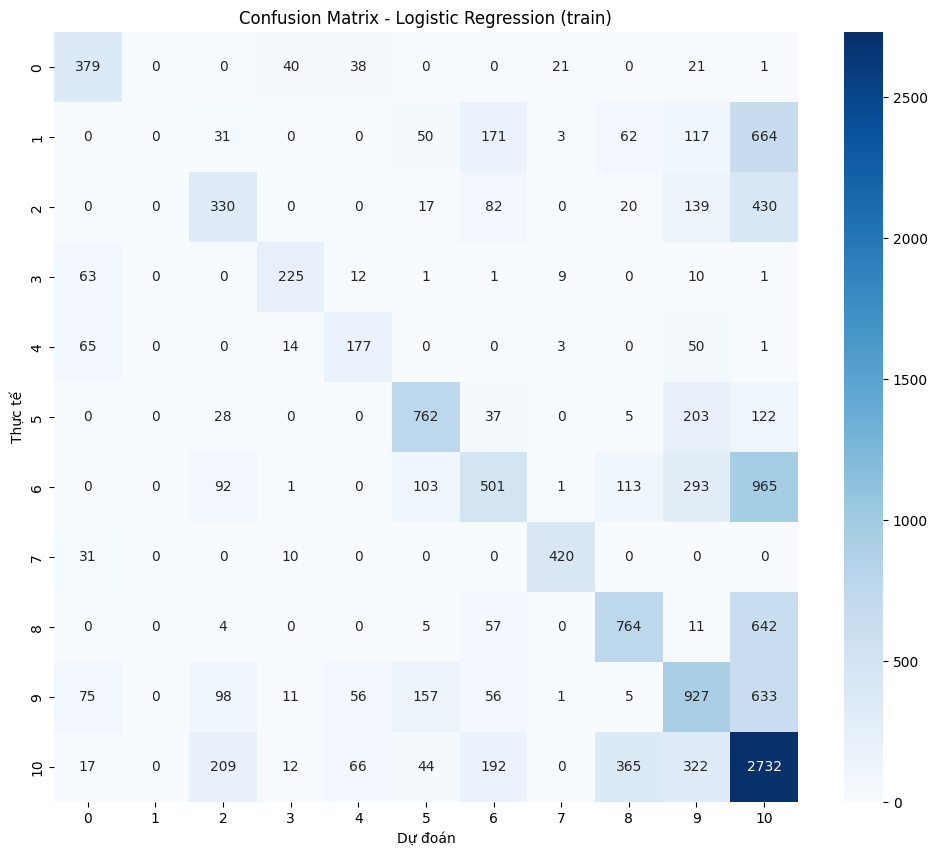

In [7]:
cm_lr = confusion_matrix(y_train, y_train_pred_lr)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression (train)')
plt.ylabel('Thực tế')
plt.xlabel('Dự đoán')
plt.show()

In [10]:
# Dự đoán trên tập test
test_predictions_lr = lr_model.predict(X_test_scaled_lr)
print(f"Số lượng dự đoán: {len(test_predictions_lr)}")

Số lượng dự đoán: 3600


### Lưu kết quả 

In [11]:
# Tạo submission file
submission_lr = pd.DataFrame({
    'Id': test_exp1['Id'],
    'Class': test_predictions_lr
})

# Lưu file submission
submission_file_path_lr = 'results/LR_submission.csv'
submission_lr.to_csv(submission_file_path_lr, index=False)
print(f"File submission đã được lưu tại: {submission_file_path_lr}")
print(f"Kích thước file submission: {submission_lr.shape}")

File submission đã được lưu tại: results/LR_submission.csv
Kích thước file submission: (3600, 2)


### Biểu diễn tổng quan bằng biểu đồ     

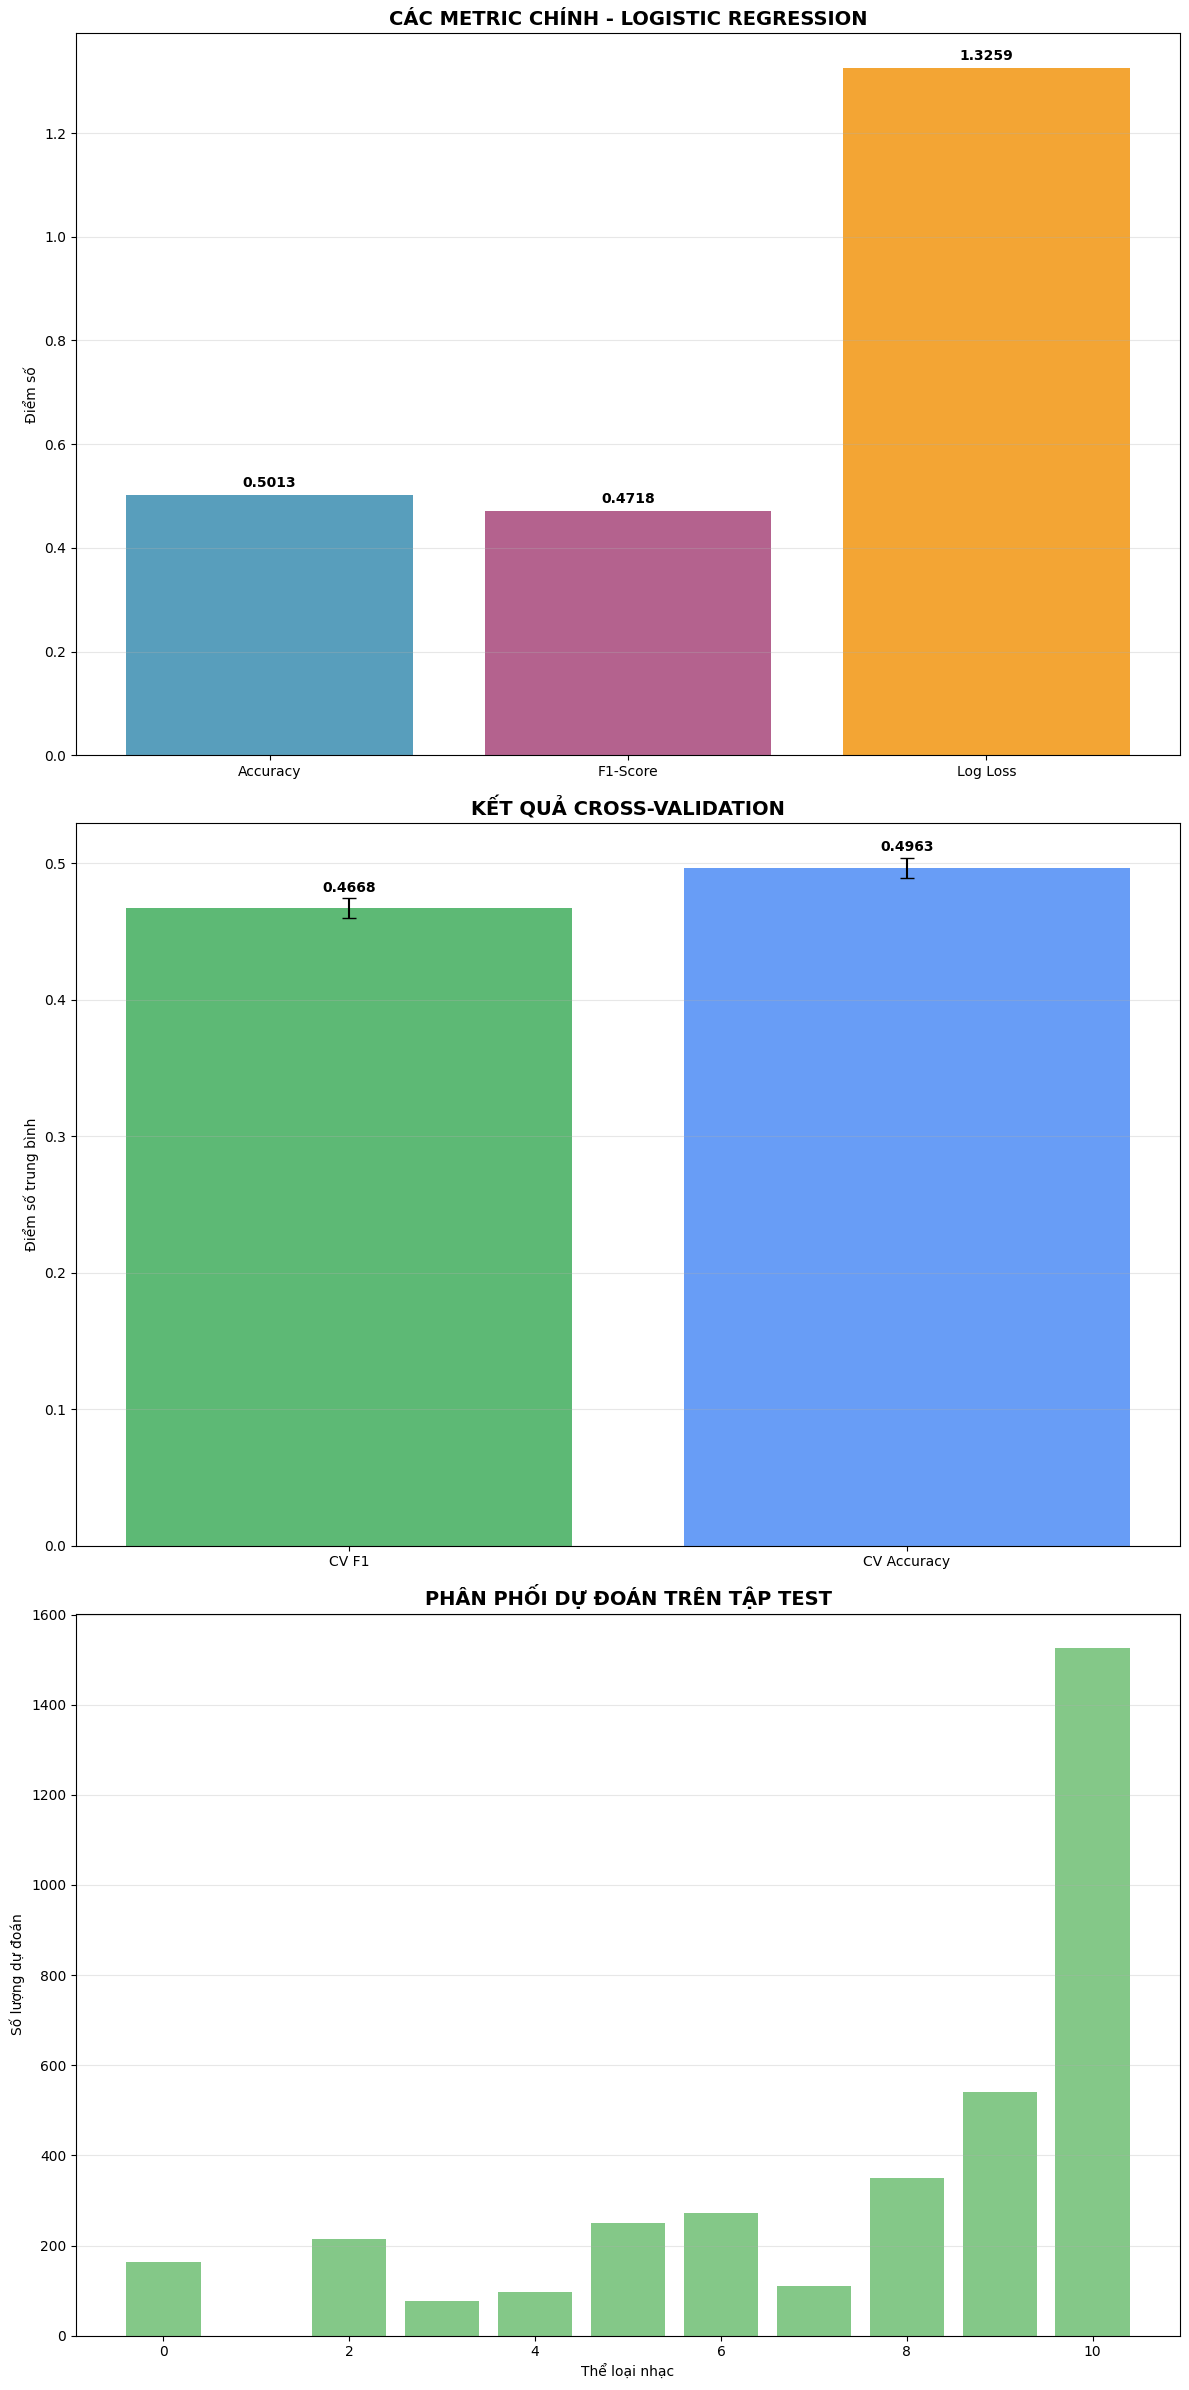

F1-Score Logistic Regression: 0.4718
F1-Score CV: 0.4668


In [12]:
fig, axes = plt.subplots(3, 1, figsize=(12, 24))

# 1. Biểu đồ metrics chính
metrics_lr = ['Accuracy', 'F1-Score', 'Log Loss']
values_lr = [train_accuracy_lr, train_f1_lr, train_log_loss_lr]
colors_lr = ['#2E86AB', '#A23B72', '#F18F01']

bars_lr = axes[0].bar(metrics_lr, values_lr, color=colors_lr, alpha=0.8)
axes[0].set_title('CÁC METRIC CHÍNH - LOGISTIC REGRESSION', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Điểm số')
axes[0].grid(axis='y', alpha=0.3)

for bar, value in zip(bars_lr, values_lr):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 2. Biểu đồ cross-validation
cv_metrics_lr = ['CV F1', 'CV Accuracy']
cv_means_lr = [cv_f1_scores_lr.mean(), cv_accuracy_scores_lr.mean()]
cv_stds_lr = [cv_f1_scores_lr.std(), cv_accuracy_scores_lr.std()]

bars_cv_lr = axes[1].bar(cv_metrics_lr, cv_means_lr, yerr=cv_stds_lr, capsize=5, 
                        color=['#34A853', '#4285F4'], alpha=0.8)
axes[1].set_title('KẾT QUẢ CROSS-VALIDATION', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Điểm số trung bình')
axes[1].grid(axis='y', alpha=0.3)

for bar, value in zip(bars_cv_lr, cv_means_lr):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# 3. Biểu đồ phân phối dự đoán
pred_distribution_lr = pd.Series(test_predictions_lr).value_counts().sort_index()
axes[2].bar(pred_distribution_lr.index, pred_distribution_lr.values, color='#66BB6A', alpha=0.8)
axes[2].set_title('PHÂN PHỐI DỰ ĐOÁN TRÊN TẬP TEST', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Thể loại nhạc')
axes[2].set_ylabel('Số lượng dự đoán')
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"F1-Score Logistic Regression: {train_f1_lr:.4f}")
print(f"F1-Score CV: {cv_f1_scores_lr.mean():.4f}")